# EfficientDet

This notebooks shows an example for training EfficientDet for deadwood *object detection* or *instance segmentation*.

In [1]:
from pathlib import Path
import sys
absolute_path = Path().absolute()
sys.path.append(str(absolute_path.parents[0]))
from drone_detector.utils import *
from drone_detector.visualizations import *

from icevision.all import *

# Read and parse data

In [73]:
parser = parsers.COCOBBoxParser('../data/analysis_data/coco.json', img_dir='../data/analysis_data/raster_tiles/')
class_map = ClassMap(['Standing deadwood', 'Fallen deadwood'])

In [74]:
train, valid = parser.parse()

  0%|          | 0/4044 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:126
AUTOFIX-START - ️🔨  Autofixing record with imageid: 164  ️🔨 | icevision.core.record:_pre_replay:89
AUTOFIX-SUCCESS - Clipping bbox ymin from -2.9802322387695312e-08 to 0 (Before: (<BBox (xmin:71.82982597406954, ymin:-2.9802322387695312e-08, xmax:114.5808033682406, ymax:61.094205409288406)>)) | icevision.core.bbox:autofix:70
AUTOFIX-START - ️🔨  Autofixing record with imageid: 296  ️🔨 | icevision.core.record:_pre_replay:89
AUTOFIX-SUCCESS - Clipping bbox ymin from -2.9802322387695312e-08 to 0 (Before: (<BBox (xmin:393.39407774526626, ymin:-2.9802322387695312e-08, xmax:398.1929429676384, ymax:1.8044513165950775)>)) | icevision.core.bbox:autofix:70
AUTOFIX-START - ️🔨  Autofixing record with imageid: 262  ️🔨 | icevision.core.record:_pre_replay:89
AUTOFIX-SUCCESS - Clipping bbox ymin from -2.9802322387695312e-08 to 0 (Before: (<BBox (xmin:333.4920092700049, ymin:-2.9802322387695312e-08, xmax:360.18896508589387, ymax:45.439344

AUTOFIX-SUCCESS - Clipping bbox ymin from -2.9802322387695312e-08 to 0 (Before: (<BBox (xmin:28.753019406460226, ymin:-2.9802322387695312e-08, xmax:103.26710538566113, ymax:63.28201246261597)>)) | icevision.core.bbox:autofix:70
AUTOFIX-START - ️🔨  Autofixing record with imageid: 526  ️🔨 | icevision.core.record:_pre_replay:89
AUTOFIX-SUCCESS - Clipping bbox ymin from -2.9802322387695312e-08 to 0 (Before: (<BBox (xmin:308.0198642555624, ymin:-2.9802322387695312e-08, xmax:318.5659100767225, ymax:31.770385771989822)>)) | icevision.core.bbox:autofix:70
AUTOFIX-SUCCESS - Clipping bbox ymin from -2.9802322387695312e-08 to 0 (Before: (<BBox (xmin:169.67710564564914, ymin:-2.9802322387695312e-08, xmax:176.90326691418886, ymax:12.658670365810394)>)) | icevision.core.bbox:autofix:70
AUTOFIX-SUCCESS - Clipping bbox ymin from -2.9802322387695312e-08 to 0 (Before: (<BBox (xmin:251.79206040408462, ymin:-2.9802322387695312e-08, xmax:292.6001847134903, ymax:322.3553322851658)>)) | icevision.core.bbox:a

AUTOFIX-SUCCESS - Clipping bbox ymin from -2.9802322387695312e-08 to 0 (Before: (<BBox (xmin:0.0, ymin:-2.9802322387695312e-08, xmax:29.180344700813293, ymax:37.450709730386734)>)) | icevision.core.bbox:autofix:70


# Set augmentations, datasets and dataloaders

`tfms.A.aug_tfms` includes various common augmentations, such as rotations, flips and random crops, as well as brightness and contrast augmenting.

For EfficientDet the images must be divisible by 128.

In [75]:
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=(384)), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(384), tfms.A.Normalize()])

In [76]:
train_ds = Dataset(train, train_tfms)
valid_ds = Dataset(valid, valid_tfms)

In [77]:
train_dl = efficientdet.train_dl(train_ds, batch_size=16, shuffle=True, num_workers=4)
valid_dl = efficientdet.valid_dl(valid_ds, batch_size=16, shuffle=False, num_workers=4)

# Init model

We use Mask R-CNN with pretrained ResNet50-backbone. IceVision provides easy ways to do this.

In [84]:
model = efficientdet.model(model_name="tf_efficientdet_d7", num_classes=len(class_map), img_size=384)

Downloading: "https://github.com/rwightman/efficientdet-pytorch/releases/download/v0.1/tf_efficientdet_d7_53-6d1d7a95.pth" to /users/mayrajan/.cache/torch/hub/checkpoints/tf_efficientdet_d7_53-6d1d7a95.pth


Make a fastai learner

In [85]:
learn = efficientdet.fastai.learner(dls=[train_dl, valid_dl], model=model)

Search for optimal learning rate for fine_tune

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.12022644281387329)

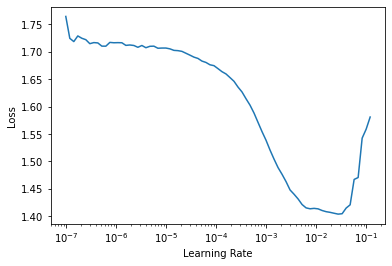

In [86]:
learn.lr_find()

# Train model

Train model quickly with 3e-3 as the maximum learning rate.

In [87]:
learn.fine_tune(30, 3e-3, freeze_epochs=3)

epoch,train_loss,valid_loss,time
0,1.481965,1.507391,00:36
1,1.316171,1.483026,00:34
2,1.218758,1.481249,00:34


epoch,train_loss,valid_loss,time
0,1.008453,0.994192,00:39
1,0.906150,0.737396,00:39
2,0.829679,0.701916,00:39
3,0.772297,0.805864,00:39
4,0.737094,0.661295,00:39
5,0.712578,0.671063,00:39
6,0.693811,0.655169,00:39
7,0.661628,0.670995,00:39
8,0.644422,0.611364,00:39
9,0.626337,0.613185,00:40


# See results

In [90]:
infer_dl = efficientdet.infer_dl(valid_ds, batch_size=1)
samples, preds = efficientdet.predict_dl(model, infer_dl)

  0%|          | 0/164 [00:00<?, ?it/s]

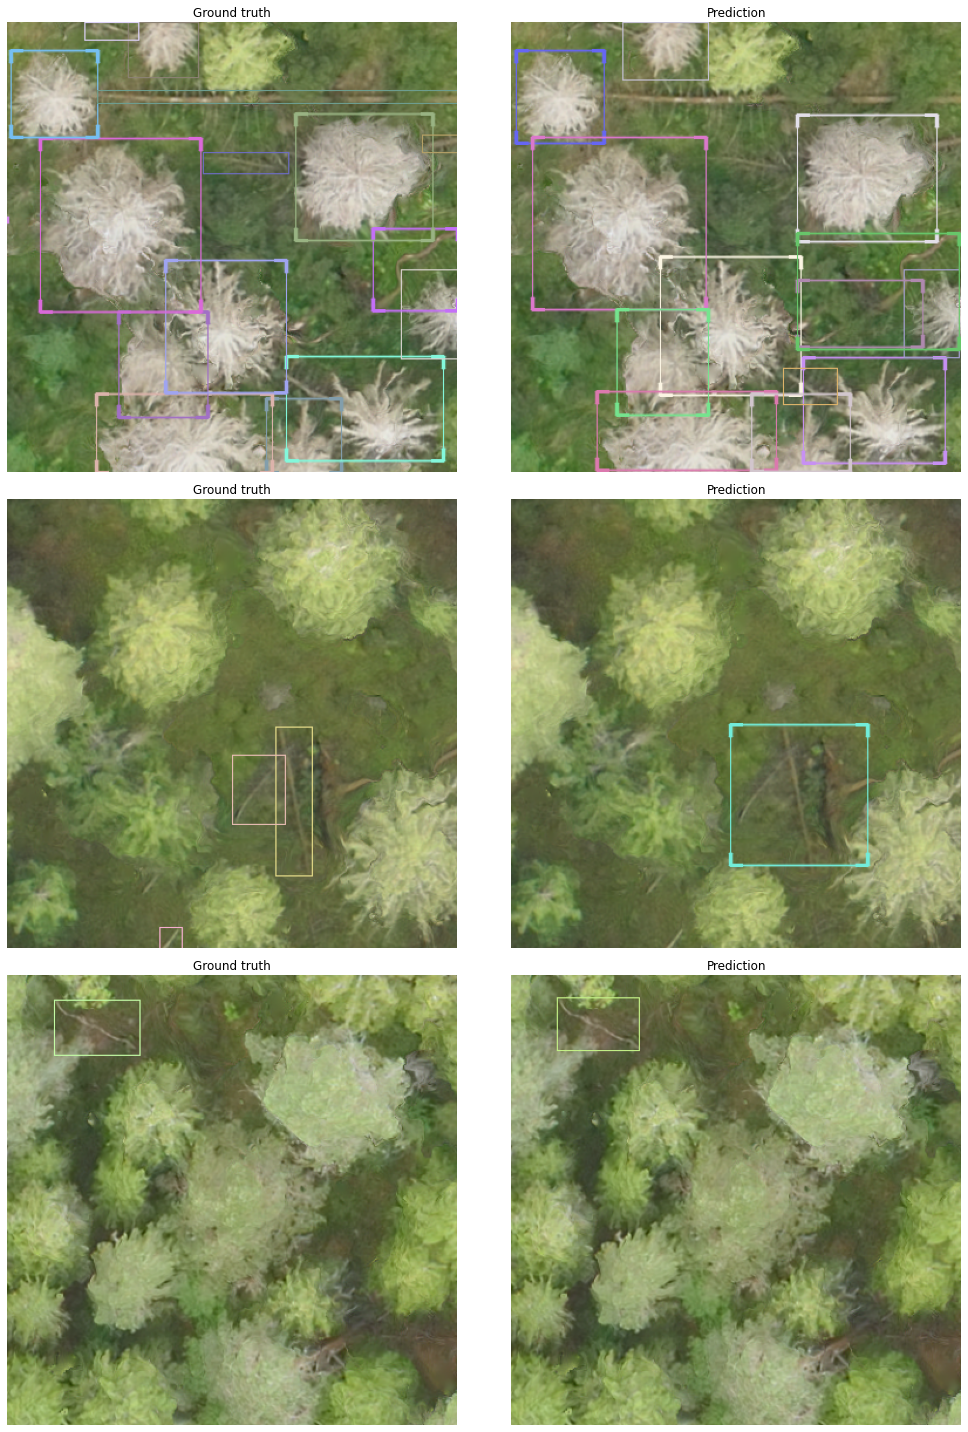

In [91]:
ix = random.randint(0, len(samples)-3)
show_preds(
    samples=samples[ix:ix+3],
    preds=preds[ix:ix+3],
    class_map=class_map,
    denormalize_fn=denormalize_imagenet,
    ncols=2,
    display_label=False,
    display_bbox=True,
    display_mask=True,
    figsize=(15,20)
)

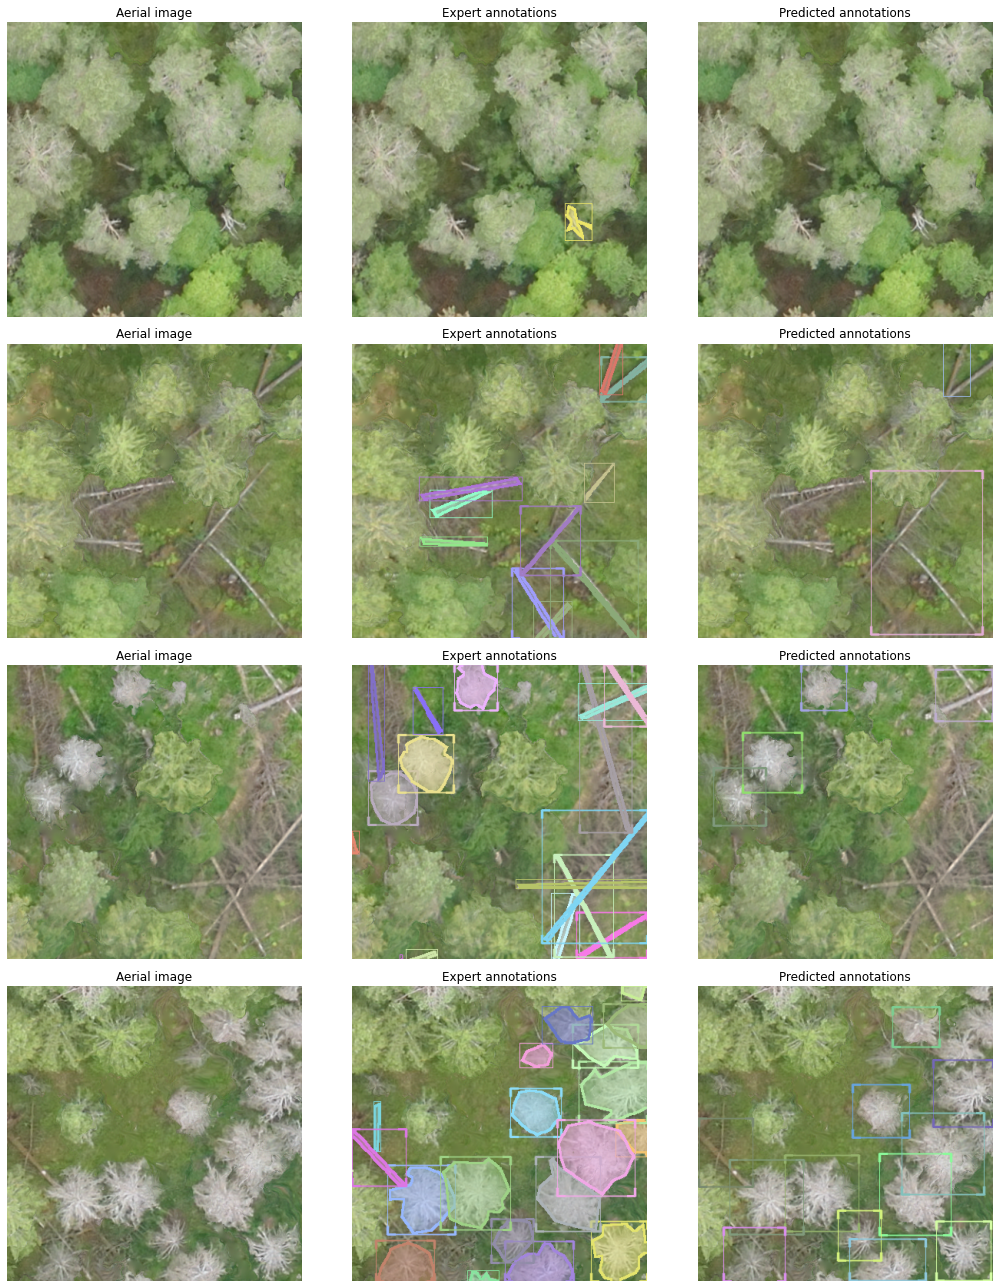

In [71]:
ix = random.randint(0, len(samples)-4)
show_raw_mask_pred(
    samples=samples[ix:ix+4],
    preds=preds[ix:ix+4],
    class_map=class_map,
    denormalize_fn=denormalize_imagenet,
    ncols=3,
    display_label=False,
    display_bbox=True,
    display_mask=True,
    figsize=(15,18)
)

# Tractor is difficult

In [49]:
import PIL

img = np.array(PIL.Image.open('../../deadwood/data/tree_patches_deadwood_sudenpesankangas/R24C17.tif'))

<AxesSubplot:>

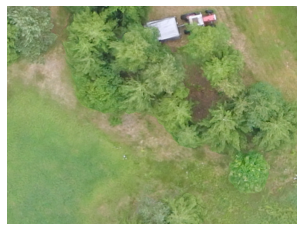

In [50]:
show_img(img)

In [52]:
infer_ds = Dataset.from_images([img], valid_tfms)
infer_dl = efficientdet.infer_dl(infer_ds, batch_size=1)
i_samples, i_preds = efficientdet.predict_dl(model=model, infer_dl=infer_dl)

  0%|          | 0/1 [00:00<?, ?it/s]

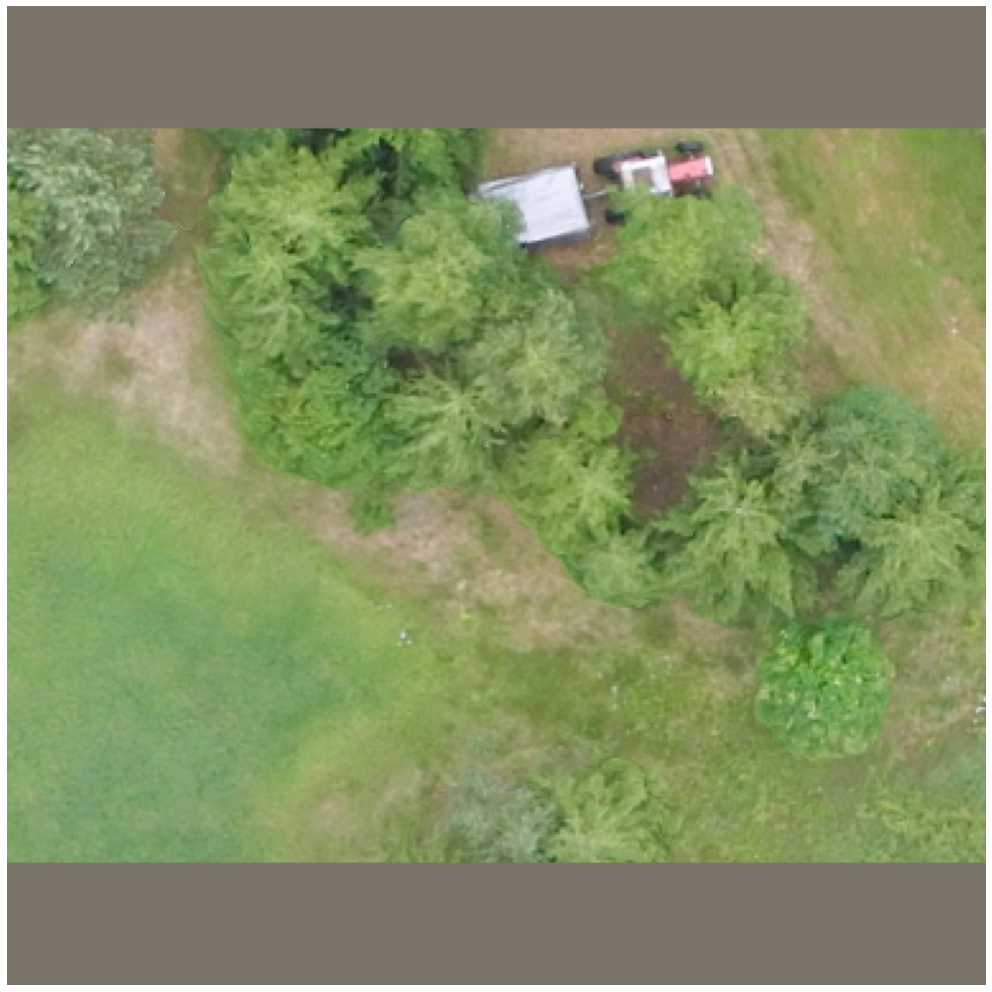

In [53]:
fig, ax = plt.subplots(figsize=(20,18))
show_pred(
    i_samples[0]['img'],
    i_preds[0],
    class_map=class_map,
    denormalize_fn=denormalize_imagenet,
    display_label=False,
    display_bbox=True,
    ax=ax
)

In [54]:
torch.save(model.state_dict(), 'models/efficientdet_tf0_lite.pth')